            FUTURE_PERCENT_PROFIT(TQQQ,5)
index_date                               
2010-02-11                              1
2010-02-12                              1
2010-02-16                              1
2010-02-17                              0
2010-02-18                              0
Generating initial population
Evaluating and culling population
Population size:  100
Best fitness:  0.5992420653718616
Crossing over the population
Mutating the population
Evaluating and culling population
Population size:  81
Best fitness:  0.599621391386654
Crossing over the population
Mutating the population
Evaluating and culling population
Population size:  68
Best fitness:  0.6016581129095934
Crossing over the population
Mutating the population
Evaluating and culling population
Population size:  53
Best fitness:  0.6070967741935483
Crossing over the population
Mutating the population
Evaluating and culling population
Population size:  43
Best fitness:  0.6070967741935483
Crossing over the p

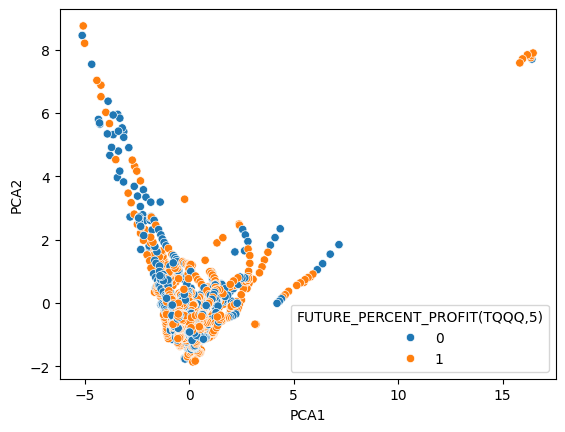

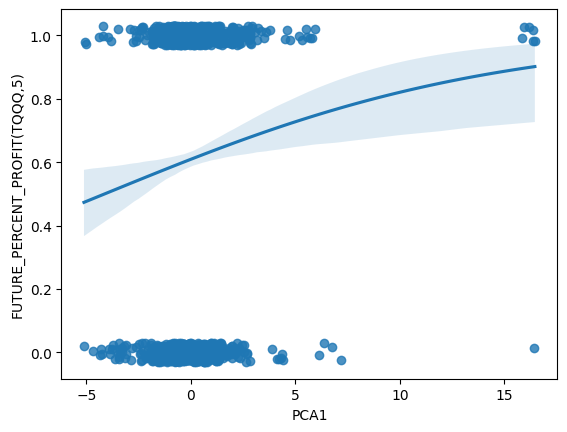

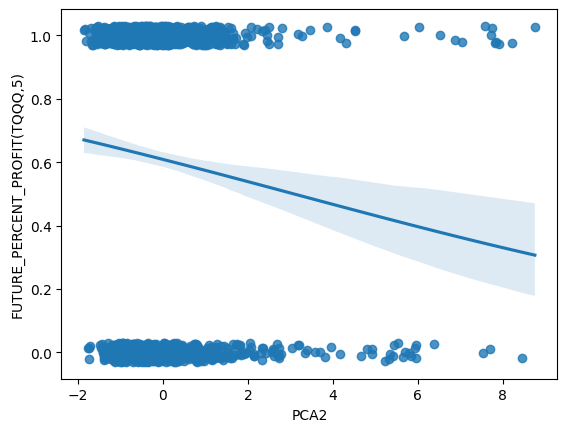

0.618766404199475

In [4]:
import random

from pynoahdb.symbolseries import SymbolSeries
from pyfunc.processor import Processor

#suppress warnings
import warnings
warnings.filterwarnings("ignore")


PARAM1_WINDOW_SIZES = [3,5,8,13,21,34,55,89,144,233]
PARAM2_WINDOW_SIZES = [5,8,13,21,34,55,89,144,233,377]

PARAM1_RATIO = [0.10,0.25,0.5,0.75,0.90]

OUTER_VARS = ["C({0})","H({0})","L({0})","O({0})","V({0})"]

FUNCTIONS = [
    ["RATIO_TO_RAVG({0},{1})",["t","w"],False],
    ["RATIO_TO_RLINEAR({0},{1})",["t","w"],False],
    ["QUANTILE_RATIO({0},{1},0.25,0.75)",["t","w"],False],
    ["QUANTILE_RATIO({0},{1},0.10,0.90)",["t","w"],False],
    ["MACDFAST({0})",["t"],False],
    ["MACDSLOW({0})",["t"],False],
    ["RSI({0},{1})",["t","w"],False],
    ["STOCH_OSC({0},{1})",["s","w"],True],
    ["RENTROPY({0},{1})",["t","w"],False],
    ["RKURT({0},{1})",["t","w"],False],
    ["RSKEW({0},{1})",["t","w"],False],
    ["RAVG_MEDIAN({0},{1})",["t","w"],False],
    ["RAVGS_RATIO({0},{1},{2})",["t","w","w"],False],
    ["RSEMS_RATIO({0},{1},{2})",["t","w","w"],False],
    ["STOCH_OSC_RAVG({0},{1},{2})",["s","w","w"],True],
    ["W_VOL_AVG({0},{1},{2})",["s","w","w"],True],
]

SYMBOL_TYPES = ["EQUITY","INDEX","ETF","CURRENCY","FRED","AGGREGATE"]

EQUITY_SYMBOLS = SymbolSeries().symbol_list("EQUITY")
INDEX_SYMBOLS = SymbolSeries().symbol_list("INDEX")
ETF_SYMBOLS = SymbolSeries().symbol_list("ETF")
CURRENCY_SYMBOLS = SymbolSeries().symbol_list("CURRENCY")
FRED_SYMBOLS = SymbolSeries().symbol_list("FRED")
AGGREGATE_SYMBOLS = SymbolSeries().symbol_list("AGGREGATE")

def generate_functions(f_count):
    #Get the symbols
    symbols = SymbolSeries().symbol_list()

    ret_list = []

    selected_functions = 0

    while selected_functions < f_count:
        #Get the function
        function = random.choice(FUNCTIONS)

        sym_type = random.choice(SYMBOL_TYPES)

        #Get the symbol
        if sym_type == "EQUITY":
            symbol = random.choice(EQUITY_SYMBOLS)
        elif sym_type == "INDEX":
            symbol = random.choice(INDEX_SYMBOLS)
        elif sym_type == "ETF":
            symbol = random.choice(ETF_SYMBOLS)
        elif sym_type == "CURRENCY":
            symbol = random.choice(CURRENCY_SYMBOLS)
        elif sym_type == "FRED":
            symbol = random.choice(FRED_SYMBOLS)
        elif sym_type == "AGGREGATE":
            symbol = random.choice(AGGREGATE_SYMBOLS)

        ##if the function requires a symbol and the symbol has only close data
        if function[2] and symbol[1]:
            continue #skip this iteration

        #Get the parameters
        params = []
        for p in function[1]:
            if p == "s":
                params.append(symbol[0])
            elif p == "w":
                params.append(random.choice(PARAM1_WINDOW_SIZES))
            elif p == "t":
                if symbol[1]:
                    params.append(f"C({symbol[0]})")
                else:
                    metric = random.choice(OUTER_VARS)
                    params.append(metric.format(symbol[0]))

        try:
            ret_list.append(Processor().process(function[0].format(*params), autoscale = True, scale_type = "robust"))
            selected_functions += 1
        except:
            continue

    return ret_list


class GeneticAlgo:
    def __init__ (self, f_generator, f_evaluator,  cull_rate = 0.5, dominant_rate = 0.5, mutation_rate = 0.05, genetic_size = 20):
        self.cull_rate = cull_rate
        self.dominant_rate = dominant_rate
        self.mutation_rate = mutation_rate
        self.genetic_size = genetic_size
        self.f_generator = f_generator
        self.f_evaluator = f_evaluator
        self.population = []

    def evaluate(self):
        print("Evaluating and culling population")
        print("Population size: ",len(self.population))
        for i in range(len(self.population)):
            self.population[i] = (self.population[i][0], self.f_evaluator(self.population[i][0]))
        #sort the population by the fitness
        self.population.sort(key=lambda x: x[1], reverse=True)

        print("Best fitness: ",self.population[0][1])

        # self.f_evaluator(self.population[0][0], show_metrics = True)



    def cull(self):
        self.population = self.population[:int(len(self.population)*(1.0-self.cull_rate))]

    def cross_over(self):
        print("Crossing over the population")
        #cross over the population
        if len(self.population) % 2 != 0:
            #duplicate the best item
            self.population.append(self.population[0])

        #shuffle the population
        random.shuffle(self.population)

        new_population = []

        for i in range(0,len(self.population),2):
            item1 = self.population[i]
            item2 = self.population[i+1]

            new_population.append(item1)
            new_population.append(item2)

            #make item1 the one with the highest fitness
            if item1[1] < item2[1]:
                item1, item2 = item2, item1

            new_item = item1[0].copy()

            #cross over the items
            for j in range(len(item1)):
                if random.random() > self.dominant_rate:
                    new_item[j] = item2[0][j]

            new_population.append((new_item,0))

        new_pop_map = {}

        for i in range(len(new_population)):
            col_names = []
            for f in new_population[i][0]:
                col_names.append(f.columns[0])

            new_pop_map['|'.join(col_names)] = new_population[i]

        self.population = list(new_pop_map.values())


            

    def mutate(self):
        print("Mutating the population")
        for i in range(len(self.population)):
            if random.random() < self.mutation_rate:
                to_mutate = random.randint(0,self.genetic_size-1)
                self.population[i][0][to_mutate] = self.f_generator(1)[0]

    def back_fill(self):
        if len(self.population) < self.stable_population_size:
            print(f"Back filling the population from {len(self.population)} to {self.stable_population_size}")
            while len(self.population) < self.stable_population_size:
                self.population.append((self.f_generator(self.genetic_size),0))

    def run(self, generations, initial_population = 200, stable_population_size = 100):
        #generate the initial population

        self.stable_population_size = stable_population_size

        print("Generating initial population")
        self.population = [(self.f_generator(self.genetic_size),0) for i in range(initial_population)]

        self.evaluate()

        #Starting generations
        for i in range(generations):
            self.cull()
            self.cross_over()
            self.mutate()
            self.back_fill()
            self.evaluate()

        return self.population
    

import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf 

#import logistic regression models
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics


import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

target_func = "FUTURE_PERCENT_PROFIT(TQQQ,5)"

DF_TARGET = Processor().process(target_func)

DF_TARGET[target_func] = DF_TARGET[target_func].apply(lambda x: 1 if x > 0 else 0)

print(DF_TARGET.head())

FUNCTION_COUNT = 20

def evaluate_functions(df_X_arr, show_metrics = False):
    try:
        df = df_X_arr[0]
        for i in range(1,len(df_X_arr)):
            df = pd.merge(df, df_X_arr[i], on='index_date', how='inner')

        #Merge the dataframes
        df = pd.merge(df, DF_TARGET, on='index_date', how='inner')

        df.dropna(inplace=True)

        #if we have less than 1000 rows, skip
        if df.shape[0] < 500:
            return -1.0
        
        Y = df[target_func]
        X = df.drop(columns=[target_func])

        Y_pos = Y[Y == 1].count()
        Y_neg = Y[Y == 0].count()

        #Compute regression weights
        weights = {0:Y_neg/(Y_pos+Y_neg), 1:Y_pos/(Y_pos+Y_neg)}

        model = LogisticRegression(class_weight=weights)
        model.fit(X, Y)
        score = model.score(X,Y)

        if show_metrics:
            Y_pred = model.predict(X)
            print("Confusion matrix: ")
            print(metrics.confusion_matrix(Y,Y_pred))
            print("Classification report: ")
            print(metrics.classification_report(Y,Y_pred))

            PCA_model = PCA(n_components=4)
            X = PCA_model.fit_transform(X)

            if show_metrics:
                print("Explained variance: ",PCA_model.explained_variance_ratio_)
                print("Sum of explained variance: ",sum(PCA_model.explained_variance_ratio_))


            #plot the 2d PCA
            df_pca = pd.DataFrame(X, columns = ["PCA1","PCA2", "PCA3", "PCA4"])

            #set the index column on df_pca
            df_pca.index = Y.index

                        

            sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue=Y)
            plt.show()

            sns.regplot(x=df_pca["PCA1"], y=Y, logistic=True, y_jitter=0.03)
            plt.show()
            sns.regplot(x=df_pca["PCA2"], y=Y, logistic=True, y_jitter=0.03)
            plt.show()


        
        return score
        
    except Exception as e:
        print(e)
        raise e
        return -1.0

algo = GeneticAlgo(generate_functions, evaluate_functions, cull_rate = 0.4, dominant_rate = 0.5, mutation_rate = 0.05, genetic_size = 10)

population = algo.run(20, initial_population = 100, stable_population_size = 40)

#sort the population by the fitness
population.sort(key=lambda x: x[1], reverse=True)

#print the columns of the best 10 items and the score
for i in range(10):
    print(population[i][1])
    functions = population[i][0]
    for f in functions:
        print(f.columns)
    print("")

#show the metrics
evaluate_functions(population[0][0], show_metrics = True)